In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead
# cleaning steps ahead

In [ ]:
df = pd.read_csv('cleaned_merged_seasons.csv')
df.head()

/tmp/ipython-input-1012819363.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('cleaned_merged_seasons.csv')


,season_x,name,position,team_x,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,influence,kickoff_time,minutes,opponent_team,opp_team_name,own_goals,penalties_missed,penalties_saved,red_cards,round,saves,selected,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,was_home,yellow_cards,GW
0,2016-17,Aaron Cresswell,DEF,NaN,0,0,0,0,0.0,454,10,0,0,0.0,0.0,2016-08-15T19:00:00Z,0,4,Chelsea,0,0,0,0,1,0,14023,1.0,2.0,0.0,0,0,0,0,55,False,0,1
1,2016-17,Aaron Lennon,MID,NaN,0,0,6,0,0.3,142,3,0,0,0.9,8.2,2016-08-13T14:00:00Z,15,17,Spurs,0,0,0,0,1,0,13918,1.0,1.0,0.0,1,0,0,0,60,True,0,1
2,2016-17,Aaron Ramsey,MID,NaN,0,0,5,0,4.9,16,8,3,0,3.0,2.2,2016-08-14T15:00:00Z,60,9,Liverpool,0,0,0,0,1,0,163170,4.0,3.0,23.0,2,0,0,0,80,True,0,1
3,2016-17,Abdoulaye Doucouré,MID,NaN,0,0,0,0,0.0,482,7,0,0,0.0,0.0,2016-08-13T14:00:00Z,0,13,Southampton,0,0,0,0,1,0,1051,1.0,1.0,0.0,0,0,0,0,50,False,0,1
4,2016-17,Adam Forshaw,MID,NaN,0,0,3,0,1.3,286,6,1,0,0.3,2.0,2016-08-13T14:00:00Z,69,14,Stoke,0,0,0,0,1,0,2723,1.0,1.0,0.0,1,0,0,0,45,True,1,1


In [ ]:
#CHANGE ALL GKP TO GK FOR CONSISTENCY

df["position"] = df["position"].str.strip().str.upper()
df.loc[df["position"] == "GKP", "position"] = "GK"


In [ ]:
#FIXING THE ICT_INDEX FOR PLAYERS WHO HAVE IT MISCALCULATED

from decimal import Decimal, ROUND_HALF_UP
import pandas as pd

for col in ["influence", "creativity", "threat", "ict_index"]:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")

# Compute the corrected ICT index
df["ict_test"] = (
    (df["influence"] + df["creativity"] + df["threat"]) / 10
).apply(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"), rounding=ROUND_HALF_UP)))

# Compare with existing ICT index
df["ict_boolean"] = (df["ict_test"].round(1) == df["ict_index"].round(1))

#counting how many inconsistency was found before
false_before = df["ict_boolean"].value_counts().get(False, 0)
print(f"Incorrect ICT index values before replacement: {false_before}")


# Replace incorrect ICT index values with correct ones
df.loc[~df["ict_boolean"], "ict_index"] = df.loc[~df["ict_boolean"], "ict_test"]
df["ict_boolean"] = (df["ict_test"].round(1) == df["ict_index"].round(1))

false_after = df["ict_boolean"].value_counts().get(False, 0)
print(f"Incorrect ICT index values after replacement: {false_after}")


Incorrect ICT index values before replacement: 1450
Incorrect ICT index values after replacement: 0


In [ ]:
#FORM COMPUTED BY RESETING FORM TO ZERO, IF THERE ARE 4 OR MORE CONSECUTIVE MISSING GAMEWEEKS#

df = df.sort_values(by=["season_x", "element", "name", "GW"]).reset_index(drop=True)

def compute_form(player_df):
    """
    For each row (match) for a player in one season, compute 'form' according to:
      - GW1 -> form = 0
      - Let g = current GW, L = max previous GW (if any), k = g - L - 1
      - If k >= 4 -> form = 0
      - Else take up to (4 - k) most recent GWs that end at L:
            [L, L-1, L-2, ...] (stop when you have 4-k games or run out)
        average their total_points and divide by 10
      - Double GWs are separate rows and count independently when present
    """
    player_df = player_df.sort_values("GW").reset_index(drop=True)
    forms = []

    for i in range(len(player_df)):
        current_gw = int(player_df.loc[i, "GW"])

        if i == 0:
            forms.append(0.0)
            continue

        prev = player_df.loc[:i-1, ["GW", "total_points"]].copy()
        if prev.empty:
            forms.append(player_df.loc[i, "total_points"] / 10.0)
            continue

        L = int(prev["GW"].max())
        k = current_gw - L - 1

        if k >= 4:
            forms.append(0.0)
            continue

        need = 4 - k
        if need <= 0:
            forms.append(0.0)
            continue

        collected_points = []
        gw_to_collect = L
        prev_indexed = prev.reset_index(drop=True)

        while len(collected_points) < need:
            matches = prev_indexed[prev_indexed["GW"] == gw_to_collect]
            if matches.empty:
                break
            for _, row in matches.iterrows():
                if len(collected_points) < need:
                    collected_points.append(row["total_points"])
                else:
                    break
            gw_to_collect -= 1

        if len(collected_points) == 0:
            form_value = player_df.loc[i, "total_points"] / 10.0
        else:
            avg_points = sum(collected_points) / len(collected_points)
            form_value = avg_points / 10.0

        forms.append(form_value)

    player_df["form"] = forms
    return player_df

#Compute form per unique player element per season
df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form)

#Resort for final CSV (alphabetically by name, then by season, then by GW)
df = df.sort_values(by=["season_x", "name", "GW"]).reset_index(drop=True)

#Preview sample
print(df[["season_x", "element", "name", "GW", "total_points", "form"]].head(20))

#Save final output
output_path = "/kaggle/working/form_final_sorted_by_name.csv"
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")


/tmp/ipykernel_197/2668672438.py:71: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form)


   season_x  element             name  GW  total_points   form
0   2016-17      454  Aaron Cresswell   1             0  0.000
1   2016-17      454  Aaron Cresswell   2             0  0.000
2   2016-17      454  Aaron Cresswell   3             0  0.000
3   2016-17      454  Aaron Cresswell   4             0  0.000
4   2016-17      454  Aaron Cresswell   5             0  0.000
5   2016-17      454  Aaron Cresswell   6             0  0.000
6   2016-17      454  Aaron Cresswell   7             0  0.000
7   2016-17      454  Aaron Cresswell   8             6  0.000
8   2016-17      454  Aaron Cresswell   9             0  0.150
9   2016-17      454  Aaron Cresswell  10             1  0.150
10  2016-17      454  Aaron Cresswell  11             2  0.175
11  2016-17      454  Aaron Cresswell  12             1  0.225
12  2016-17      454  Aaron Cresswell  13             1  0.100
13  2016-17      454  Aaron Cresswell  14             0  0.125
14  2016-17      454  Aaron Cresswell  15             1

In [ ]:
#FORM COMPUTED BY AVERAGING THE TOTAL POINTS OF ALL WEEKS FOR THE PLAYER IF THERE ARE 4 OR MORE CONSECUTIVE MISSING GAMEWEEKS#

df = pd.read_csv('/kaggle/working/form_final_sorted_by_name.csv')
# Sort for stable group computations
df = df.sort_values(by=["season_x", "element", "name", "GW"]).reset_index(drop=True)

def compute_form_avg(player_df):
    """
    Similar to compute_form, but when there are 4 or more consecutive missing GWs,
    the form is set to the player's average total_points for the season divided by 10.
    """
    player_df = player_df.sort_values("GW").reset_index(drop=True)
    forms_avg = []

    # Precompute season average (avoid recomputing every iteration)
    season_avg_points = player_df["total_points"].mean() / 10.0

    for i in range(len(player_df)):
        current_gw = int(player_df.loc[i, "GW"])

        if i == 0:
            first_gw = int(player_df.loc[i, "GW"])
            if first_gw >= 5:
                forms_avg.append(season_avg_points)
            else:
                forms_avg.append(0.0)
            continue

        prev = player_df.loc[:i-1, ["GW", "total_points"]].copy()
        if prev.empty:
            forms_avg.append(player_df.loc[i, "total_points"] / 10.0)
            continue

        L = int(prev["GW"].max())
        k = current_gw - L - 1

        #when k >= 4, use season's total points average instead of 0
        if k >= 4:
            forms_avg.append(season_avg_points)
            continue

        need = 4 - k
        if need <= 0:
            forms_avg.append(season_avg_points)
            continue

        collected_points = []
        gw_to_collect = L
        prev_indexed = prev.reset_index(drop=True)

        while len(collected_points) < need:
            matches = prev_indexed[prev_indexed["GW"] == gw_to_collect]
            if matches.empty:
                break
            for _, row in matches.iterrows():
                if len(collected_points) < need:
                    collected_points.append(row["total_points"])
                else:
                    break
            gw_to_collect -= 1

        if len(collected_points) == 0:
            form_value = player_df.loc[i, "total_points"] / 10.0
        else:
            avg_points = sum(collected_points) / len(collected_points)
            form_value = avg_points / 10.0

        forms_avg.append(form_value)

    player_df["form_avg"] = forms_avg
    return player_df


#Compute form_avg per unique player element per season
df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form_avg)

#Preview results
print(df[["season_x", "element", "name", "GW", "total_points", "form_avg"]].head(20))

#Save updated CSV
output_path = "/kaggle/working/form_with_form_avg.csv"
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")


/tmp/ipykernel_197/3650729638.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/working/form_final_sorted_by_name.csv')
/tmp/ipykernel_197/3650729638.py:75: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df = df.groupby(["season_x", "element", "name"], group_keys=False).apply(compute_form_avg)


   season_x  element             name  GW  total_points  form_avg
0   2016-17        6  Héctor Bellerín   1             0  0.000000
1   2016-17        6  Héctor Bellerín   2             9  0.000000
2   2016-17        6  Héctor Bellerín   3             2  0.450000
3   2016-17        6  Héctor Bellerín   4             2  0.366667
4   2016-17        6  Héctor Bellerín   5             2  0.325000
5   2016-17        6  Héctor Bellerín   6            11  0.375000
6   2016-17        6  Héctor Bellerín   7             6  0.425000
7   2016-17        6  Héctor Bellerín   8             4  0.525000
8   2016-17        6  Héctor Bellerín   9             7  0.575000
9   2016-17        6  Héctor Bellerín  10             2  0.700000
10  2016-17        6  Héctor Bellerín  11             2  0.475000
11  2016-17        6  Héctor Bellerín  12             0  0.375000
12  2016-17        6  Héctor Bellerín  13             0  0.275000
13  2016-17        6  Héctor Bellerín  14             0  0.100000
14  2016-1

In [ ]:
#FILLING IN TEAM_X FOR MISSING VALUES


df = pd.read_csv('/kaggle/working/form_with_form_avg.csv')

def normalize_text_col(s):
    # keep NaN as NaN, otherwise strip and map empty-like tokens to NaN
    if pd.isna(s):
        return np.nan
    s = str(s).strip()
    if s == "" or s.lower() in {"nan", "none", "na"}:
        return np.nan
    return s

# Apply normalization to the columns we depend on
for col in ["team_x", "opp_team_name", "fixture", "season_x"]:
    if col in df.columns:
        df[col] = df[col].apply(normalize_text_col)

# Quick diagnostics before
total_rows = len(df)
missing_before = df["team_x"].isna().sum()
print(f"Total rows: {total_rows}")
print(f"Missing team_x BEFORE: {missing_before}")

# 2) Build lookup of groups by (season_x, fixture)
# Only include groups where fixture is not null (can't infer without fixture)
grouped = {}
for (season, fixture), g in df.groupby(["season_x", "fixture"]):
    grouped[(season, fixture)] = g

# 3) Fill only missing rows and collect diagnostics
filled_count = 0
filled_examples = []
not_filled_examples = []

def infer_team_for_row(row, grouped):
    # row is a Series
    fixture = row["fixture"]
    season = row["season_x"]
    opponent = row.get("opp_team_name", None)

    if pd.isna(fixture) or pd.isna(season):
        return np.nan, "no_fixture_or_season"

    grp = grouped.get((season, fixture))
    if grp is None or grp.empty:
        return np.nan, "no_group_found"

    # 1) Direct mapping: find rows in same fixture whose opp_team_name == this row's opp_team_name
    #    and which have team_x present; those rows' team_x are candidates for this player's team_x.
    if opponent is not None:
        candidates = grp.loc[(grp["opp_team_name"] == opponent) & grp["team_x"].notna(), "team_x"].unique()
        if len(candidates) > 0:
            return candidates[0], "direct_candidate"

    # 2) Fallback by elimination: if exactly two distinct opp_team_name values present,
    #    pick the one that is NOT this row's opponent.
    distinct_opps = grp["opp_team_name"].dropna().unique().tolist()
    if len(distinct_opps) == 2 and opponent is not None:
        other = [t for t in distinct_opps if t != opponent]
        if len(other) == 1:
            return other[0], "inferred_by_elimination"

    # 3) If group has team_x values for some rows, but none directly match, try other heuristics:
    #    - If there is exactly one unique non-null team_x in group, assume both rows belong to single team (rare).
    teamx_vals = grp["team_x"].dropna().unique().tolist()
    if len(teamx_vals) == 1:
        return teamx_vals[0], "single_teamx_in_group"

    # 4) Nothing good — return NaN
    return np.nan, "could_not_infer"

# Apply only on rows where team_x is missing
mask_missing = df["team_x"].isna()
rows_to_process = df[mask_missing].copy()

# We'll store the inferred results in a column and a reason
inferred = []
reasons = []
for idx, r in rows_to_process.iterrows():
    val, reason = infer_team_for_row(r, grouped)
    inferred.append(val)
    reasons.append(reason)

# Put back into the dataframe (only for the missing rows)
df.loc[mask_missing, "team_x_filled_candidate"] = inferred
df.loc[mask_missing, "team_x_fill_reason"] = reasons

# Merge only where missing
before_missing = df["team_x"].isna().sum()
df["team_x"] = df["team_x"].fillna(df["team_x_filled_candidate"])
after_missing = df["team_x"].isna().sum()
filled_count = before_missing - after_missing

# Collect small samples for debugging
filled_examples = df.loc[df["team_x_fill_reason"].notna() & df["team_x"].notna(),
                         ["season_x","fixture","name","opp_team_name","team_x","team_x_fill_reason"]].head(10)
not_filled_examples = df.loc[df["team_x"].isna(), ["season_x","fixture","name","opp_team_name"]].head(10)

print(f"Filled this run: {filled_count}")
print("Sample filled rows (up to 10):")
print(filled_examples.to_string(index=False))

print(f"Remaining missing team_x AFTER: {after_missing}")
print("Sample not-filled rows (up to 10):")
print(not_filled_examples.to_string(index=False))

# Cleanup helper columns
df.drop(columns=["team_x_filled_candidate","team_x_fill_reason"], errors='ignore', inplace=True)

output_path = f"/kaggle/working/fantasy_with_filled_teams.csv"
df.to_csv(output_path, index=False)
print(f"Saved to: {output_path}")

/tmp/ipykernel_197/1982959916.py:4: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/kaggle/working/form_with_form_avg.csv')


Total rows: 96169
Missing team_x BEFORE: 19852
Filled this run: 19852
Sample filled rows (up to 10):
season_x fixture            name opp_team_name  team_x      team_x_fill_reason
 2016-17       8 Héctor Bellerín     Liverpool Arsenal inferred_by_elimination
 2016-17      13 Héctor Bellerín     Leicester Arsenal inferred_by_elimination
 2016-17      28 Héctor Bellerín       Watford Arsenal inferred_by_elimination
 2016-17      31 Héctor Bellerín   Southampton Arsenal inferred_by_elimination
 2016-17      43 Héctor Bellerín          Hull Arsenal inferred_by_elimination
 2016-17      51 Héctor Bellerín       Chelsea Arsenal inferred_by_elimination
 2016-17      61 Héctor Bellerín       Burnley Arsenal inferred_by_elimination
 2016-17      71 Héctor Bellerín       Swansea Arsenal inferred_by_elimination
 2016-17      81 Héctor Bellerín Middlesbrough Arsenal inferred_by_elimination
 2016-17      97 Héctor Bellerín    Sunderland Arsenal inferred_by_elimination
Remaining missing team_x AFTER

In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

def expected_points_def(row):
    pts = 0
    if 0 < row['minutes'] < 60:
        pts += 1
    elif row['minutes'] >= 60:
        pts += 2
    pts += (
        6 * row['goals_scored'] +
        3 * row['assists'] +
        4 * row['clean_sheets'] * (row['minutes'] >= 60) +
        (-1) * np.floor(row['goals_conceded'] / 2) +
        (-2) * row['penalties_missed'] +
        (-2) * row['own_goals'] +
        (-3) * row['red_cards'] +
        (-1) * row['yellow_cards'] +
        row['bonus']
    )
    return pts

def expected_points_mid(row):
    pts = 0
    if 0 < row['minutes'] < 60:
        pts += 1
    elif row['minutes'] >= 60:
        pts += 2
    pts += (
        5 * row['goals_scored'] +
        3 * row['assists'] +
        1 * row['clean_sheets'] * (row['minutes'] >= 60) +
        (-2) * row['penalties_missed'] +
        (-2) * row['own_goals'] +
        (-3) * row['red_cards'] +
        (-1) * row['yellow_cards'] +
        row['bonus']
    )
    return pts

def expected_points_fwd(row):
    pts = 0
    if 0 < row['minutes'] < 60:
        pts += 1
    elif row['minutes'] >= 60:
        pts += 2
    pts += (
        4 * row['goals_scored'] +
        3 * row['assists'] +
        (-2) * row['penalties_missed'] +
        (-2) * row['own_goals'] +
        (-3) * row['red_cards'] +
        (-1) * row['yellow_cards'] +
        row['bonus']
    )
    return pts

def calc_expected_points(row):
    if row['position'] == 'DEF':
        return expected_points_def(row)
    elif row['position'] == 'MID':
        return expected_points_mid(row)
    elif row['position'] == 'FWD':
        return expected_points_fwd(row)
    else:
        return 0

df_outfield = df[df['position'].isin(['DEF', 'MID', 'FWD'])].copy()

iteration = 0
while True:
    iteration += 1
    print(f"\n Iteration {iteration}")

    df_outfield['expected_points'] = df_outfield.apply(calc_expected_points, axis=1)
    df_outfield['difference'] = df_outfield['total_points'] - df_outfield['expected_points']

    inconsistencies = df_outfield[df_outfield['difference'] != 0].copy()
    print(f" Found {len(inconsistencies)} inconsistent rows.")

    if len(inconsistencies) == 0:
        break

    updated_positions = []

    for idx, row in inconsistencies.iterrows():
        name = row['name']
        total_points = row['total_points']
        original_position = row['position']

        if pd.isnull(total_points):
            continue

        def_pts = expected_points_def(row)
        mid_pts = expected_points_mid(row)
        fwd_pts = expected_points_fwd(row)

        diffs = {
            'DEF': abs(total_points - def_pts),
            'MID': abs(total_points - mid_pts),
            'FWD': abs(total_points - fwd_pts)
        }

        best_pos = min(diffs, key=diffs.get)

        if best_pos != original_position and diffs[best_pos] == 0:
            df_outfield.loc[idx, 'position'] = best_pos
            updated_positions.append((name, original_position, best_pos))
            season = row['season_x']
            df_outfield.loc[(df_outfield['name'] == name) & (df_outfield['season_x'] == season), 'position'] = best_pos

    print(f" Updated {len(updated_positions)} player positions this iteration.")

df.update(df_outfield)
output_path = "fpl_positions_corrected.csv"
df.to_csv(output_path, index=False)
print(f"\n Updated positions saved to '{output_path}' successfully!")

remaining = df_outfield[df_outfield['difference'] != 0]
if not remaining.empty:
    cols = ['season_x', 'GW', 'name', 'team_x', 'position', 'minutes', 'total_points', 'expected_points', 'difference']
    display(remaining[cols])



🔄 Iteration 1
⚠️ Found 340 inconsistent rows.
✅ Updated 340 player positions this iteration.

🔄 Iteration 2
⚠️ Found 22 inconsistent rows.
✅ Updated 22 player positions this iteration.

🔄 Iteration 3
⚠️ Found 0 inconsistent rows.

💾 Updated positions saved to 'fpl_positions_corrected.csv' successfully!


In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)


df_def = df[df['position'] == 'DEF'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    6 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    4 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    (-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']


inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent defender rows:", len(inconsistencies))


cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

#print(inconsistencies[cols_to_show])

unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent defenders: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per defender:")
print(player_counts)


Number of inconsistent defender rows: 0

Number of unique inconsistent defenders: 0
Players with inconsistencies:
[]

Inconsistency frequency per defender:
Series([], Name: count, dtype: int64)


In [ ]:
import numpy as np
import pandas as pd


pd.set_option('display.max_rows', None)


df_def = df[df['position'] == 'MID'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    5 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    1 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    #(-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']


inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent midfielder rows:", len(inconsistencies))


cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

#print(inconsistencies[cols_to_show])


unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent midfielders: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per midfielders:")
print(player_counts)


Number of inconsistent midfielder rows: 0

Number of unique inconsistent midfielders: 0
Players with inconsistencies:
[]

Inconsistency frequency per midfielders:
Series([], Name: count, dtype: int64)


In [ ]:
import numpy as np
import pandas as pd


pd.set_option('display.max_rows', None)


df_def = df[df['position'] == 'FWD'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    4 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    #1 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    #(-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']


inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent attacker rows:", len(inconsistencies))


cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

#print(inconsistencies[cols_to_show])


unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent attackers: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per attackers:")
print(player_counts)


Number of inconsistent attacker rows: 0

Number of unique inconsistent attackers: 0
Players with inconsistencies:
[]

Inconsistency frequency per attackers:
Series([], Name: count, dtype: int64)


In [ ]:
import pandas as pd
import numpy as np

def add_upcoming_points(df):
    # Sort globally
    df = df.sort_values(by=['season_x', 'element', 'GW', 'kickoff_time']).reset_index(drop=True)

    # Prepare the output column
    df['upcoming_total_points'] = np.nan

    def compute_group(g):
        g = g.sort_values(['GW', 'kickoff_time']).copy()
        n = len(g)
        upcoming = np.full(n, np.nan)
        avg_points = g['total_points'].mean()
        full_season = len(g) == 38

        for i in range(n):
            current_gw = g.iloc[i]['GW']

            # If it's the last game, no upcoming GW
            if i == n - 1 or current_gw == 38:
                upcoming[i] = 0
                continue

            next_gw = g.iloc[i + 1]['GW']

            # Case 1: Double GW (same GW)
            if next_gw == current_gw:
                upcoming[i] = g.iloc[i + 1]['total_points']
                continue

            # Case 2: Consecutive GW (GW + 1)
            if next_gw == current_gw + 1:
                upcoming[i] = g.iloc[i + 1]['total_points']
                continue

            # Case 3: Non-consecutive GW (gap)
            if full_season:
                # For full season → find next valid GW below
                next_rows = g.iloc[i + 1:][g.iloc[i + 1:]['GW'] > current_gw]
                if not next_rows.empty:
                    upcoming[i] = next_rows.iloc[0]['total_points']
                else:
                    upcoming[i] = round(avg_points)
            else:
                # For partial season, directly use average when GW gap found
                upcoming[i] = round(avg_points)

        g['upcoming_total_points'] = upcoming.astype(int)
        return g

    # Apply to each (season, element)
    df = df.groupby(['season_x', 'element'], group_keys=False).apply(compute_group)

    df['upcoming_total_points'] = df['upcoming_total_points'].astype(int)
    return df

In [ ]:
df = add_upcoming_points(df)

In [ ]:
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead
# Analysis Ahead

In [ ]:
df.describe()

In [ ]:
problem_cases = []

# Get all unique (season, player) combinations
unique_pairs = df[['season_x', 'name']].drop_duplicates()

for _, pair in unique_pairs.iterrows():
    season = pair['season_x']
    player = pair['name']

    # Get all rows for this player in this season
    player_data = df[(df['season_x'] == season) & (df['name'] == player)]

    # Count how many matches (rows)
    num_rows = len(player_data)

    # Check if GW 38 exists for this player-season
    has_gw38 = 38 in player_data['GW'].values

    # If player has 38 matches but no GW 38 → add to list
    if num_rows == 38 and not has_gw38:
        problem_cases.append({
            'season_x': season,
            'name': player,
            'num_rows': num_rows,
            'has_gw38': has_gw38
        })

# Convert the list of dicts to a DataFrame
problem_cases_df = pd.DataFrame(problem_cases)

print(problem_cases_df)

In [ ]:
pd.set_option('display.max_rows', None)
player_name = "Kevin De Bruyne"
season = "2017-18"

player_season_df = df[(df['name'] == player_name) & (df['season_x'] == season)]
player_season_df
# Pierre-Emerick Aubameyang
#Sergio Agüero
#Kevin De Bruyne


player_season_df = df[(df['name'] == player_name) & (df['season_x'] == season)]
player_season_df

In [ ]:
df['position'].value_counts()

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96169 entries, 0 to 96168
Data columns (total 37 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   season_x           96169 non-null  object 
 1   name               96169 non-null  object 
 2   position           96169 non-null  object 
 3   team_x             76317 non-null  object 
 4   assists            96169 non-null  int64  
 5   bonus              96169 non-null  int64  
 6   bps                96169 non-null  int64  
 7   clean_sheets       96169 non-null  int64  
 8   creativity         96169 non-null  float64
 9   element            96169 non-null  int64  
 10  fixture            96169 non-null  int64  
 11  goals_conceded     96169 non-null  int64  
 12  goals_scored       96169 non-null  int64  
 13  ict_index          96169 non-null  float64
 14  influence          96169 non-null  float64
 15  kickoff_time       96169 non-null  object 
 16  minutes            961

In [ ]:
df.describe()

,assists,bonus,bps,clean_sheets,creativity,element,fixture,goals_conceded,goals_scored,ict_index,...,team_a_score,team_h_score,threat,total_points,transfers_balance,transfers_in,transfers_out,value,yellow_cards,GW
count,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,96169.000000,...,96169.000000,96169.000000,96169.000000,96169.000000,9.616900e+04,9.616900e+04,9.616900e+04,96169.000000,96169.000000,96169.000000
mean,0.041042,0.108715,6.080275,0.106739,4.734000,327.063264,198.413824,0.495887,0.045514,1.715793,...,1.265158,1.516393,5.287598,1.379270,1.677100e+03,1.454716e+04,1.286945e+04,51.352390,0.053167,20.772099
std,0.215378,0.492334,9.850595,0.308783,10.689879,194.313766,108.884200,0.974269,0.233644,3.042551,...,1.229086,1.349184,13.368420,2.542535,6.581628e+04,5.725343e+04,4.840128e+04,12.667432,0.224367,10.941742
min,0.000000,0.000000,-21.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,-7.000000,-2.180978e+06,0.000000e+00,0.000000e+00,37.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,159.000000,105.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,-1.374000e+03,4.600000e+01,1.280000e+02,44.000000,0.000000,11.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,318.000000,203.000000,0.000000,0.000000,0.000000,...,1.000000,1.000000,0.000000,0.000000,-5.800000e+01,4.380000e+02,1.104000e+03,48.000000,0.000000,22.000000
75%,0.000000,0.000000,10.000000,0.000000,2.400000,486.000000,293.000000,1.000000,0.000000,2.500000,...,2.000000,2.000000,2.000000,2.000000,7.900000e+01,5.042000e+03,7.562000e+03,54.000000,0.000000,30.000000
max,4.000000,3.000000,128.000000,1.000000,170.900000,778.000000,380.000000,9.000000,4.000000,32.800000,...,7.000000,9.000000,186.000000,29.000000,1.983733e+06,2.104464e+06,2.233619e+06,133.000000,1.000000,38.000000


In [ ]:
df.isnull().sum()

,0
season_x,0
name,0
position,0
team_x,19852
assists,0
bonus,0
bps,0
clean_sheets,0
creativity,0
element,0


<Axes: >

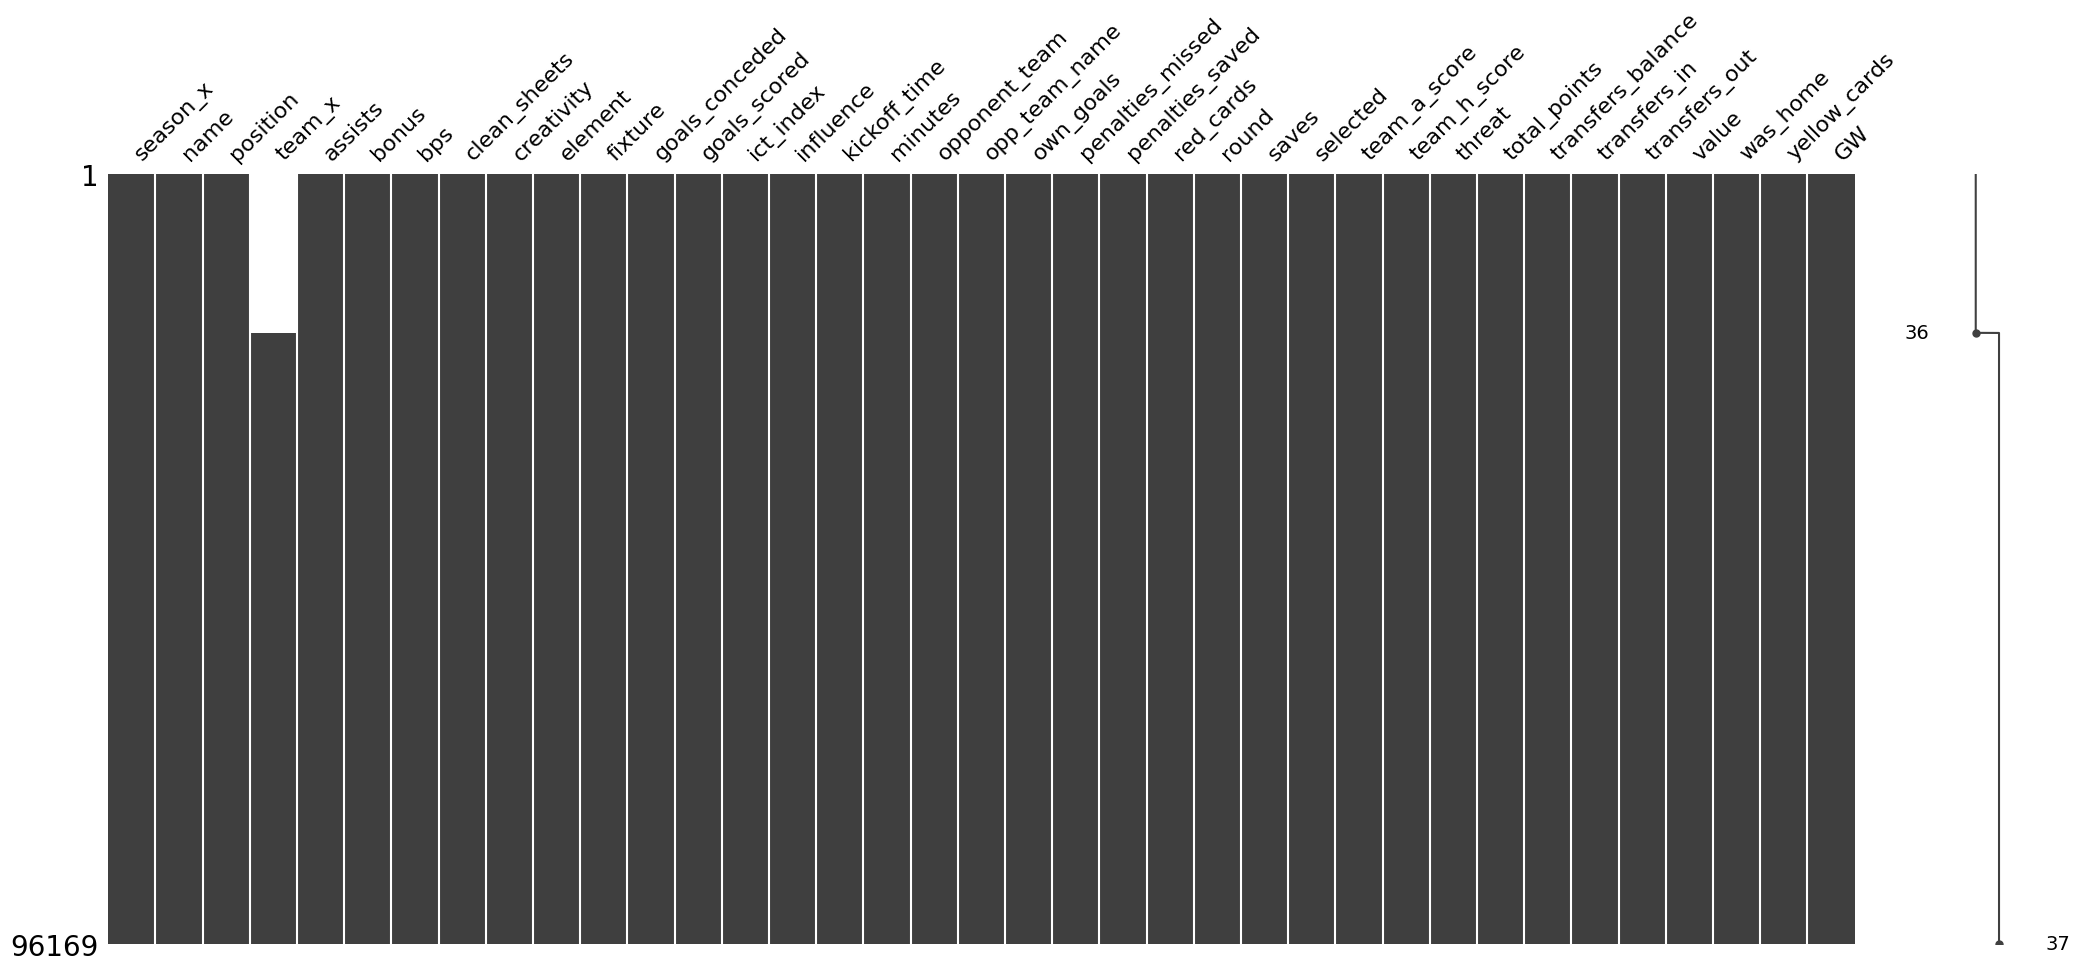

In [ ]:
import missingno as msno
msno.matrix(df)

In [ ]:
df.duplicated().sum()

np.int64(0)

In [ ]:
# Count how many rows for each assists value
df['goals_conceded'].value_counts() #bonus

,count
goals_conceded,
0,69673
1,13607
2,7425
3,3503
4,1345
5,446
6,110
7,43
9,16


In [ ]:
import pandas as pd
# dih kan fhia bigger than zero bardo
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

players_with_points_but_no_minutes = df[(df['minutes'] == 0) & (df['total_points'] < 0)] #mara bl >0 as well

cols_to_show = [
    'season_x', 'GW', 'name', 'team_x',
    'minutes', 'total_points', 'position'
]
print(players_with_points_but_no_minutes[cols_to_show].to_string(index=False))

print("\nCount:", len(players_with_points_but_no_minutes))


season_x  GW                      name    team_x  minutes  total_points position
 2017-18  17                 Sam Field       NaN        0            -1      MID
 2017-18  38 Ederson Santana de Moraes       NaN        0            -1       GK
 2020-21  37            Daniel Amartey Leicester        0            -1      DEF
 2021-22  30              Nohan Kenneh     Leeds        0            -1      MID
 2022-23  16          Jamaal Lascelles Newcastle        0            -1      DEF
 2022-23  19          Jamaal Lascelles Newcastle        0            -1      DEF
 2022-23  28        Matheus Luiz Nunes    Wolves        0            -3      MID

Count: 7


In [ ]:
df['clean_sheets'].value_counts()

,count
clean_sheets,
0,85904
1,10265


In [ ]:
import numpy as np
import pandas as pd

df_gk = df[df['position'].isin(['GK', 'GKP'])].copy()

df_gk['expected_points'] = 0

df_gk.loc[(df_gk['minutes'] > 0) & (df_gk['minutes'] < 60), 'expected_points'] += 1
df_gk.loc[df_gk['minutes'] >= 60, 'expected_points'] += 2

df_gk['expected_points'] += (
    6 * df_gk['goals_scored'] +                               # goals scored (rare for GKs)
    3 * df_gk['assists'] +                                    # assists (+3 each)
    4 * df_gk['clean_sheets'] * (df_gk['minutes'] >= 60) +    # clean sheets (60+ mins)
    (-1) * np.floor(df_gk['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    np.floor(df_gk['saves'] / 3) +                            # +1 per 3 saves
    5 * df_gk['penalties_saved'] +                            # +5 per penalty saved
    (-2) * df_gk['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_gk['own_goals'] +                               # -2 per own goal
    (-3) * df_gk['red_cards'] +                               # -3 per red card
    (-1) * df_gk['yellow_cards'] +                            # -1 per yellow card
    df_gk['bonus']                                            # bonus points
)

df_gk['difference'] = df_gk['total_points'] - df_gk['expected_points']

inconsistencies = df_gk[df_gk['difference'] != 0]

print("Number of inconsistent goalkeeper rows:", len(inconsistencies))

cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

inconsistencies[cols_to_show]

unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent goalkeeper: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)

player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per goalkeeper:")
print(player_counts)


Number of inconsistent goalkeeper rows: 0

Number of unique inconsistent goalkeeper: 0
Players with inconsistencies:
[]

Inconsistency frequency per goalkeeper:
Series([], Name: count, dtype: int64)


In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

df_def = df[df['position'] == 'DEF'].copy()

df_def['expected_points'] = 0

df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2

df_def['expected_points'] += (
    6 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    4 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    (-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)

df_def['difference'] = df_def['total_points'] - df_def['expected_points']

inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent defender rows:", len(inconsistencies))

cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

print(inconsistencies[cols_to_show])

unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent defenders: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)

player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per defender:")
print(player_counts)


Number of inconsistent defender rows: 0
Empty DataFrame
Columns: [season_x, GW, name, team_x, minutes, expected_points, total_points, difference]
Index: []

Number of unique inconsistent defenders: 0
Players with inconsistencies:
[]

Inconsistency frequency per defender:
Series([], Name: count, dtype: int64)


In [ ]:
import numpy as np
import pandas as pd

pd.set_option('display.max_rows', None)

df_def = df[df['position'] == 'MID'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    5 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    1 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    #(-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']


inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent midfielders rows:", len(inconsistencies))


cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

inconsistencies[cols_to_show]


unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent midfielders: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per midfielders:")
print(player_counts)



Number of inconsistent midfielders rows: 0

Number of unique inconsistent midfielders: 0
Players with inconsistencies:
[]

Inconsistency frequency per midfielders:
Series([], Name: count, dtype: int64)


In [ ]:
import numpy as np
import pandas as pd


pd.set_option('display.max_rows', None)


df_def = df[df['position'] == 'FWD'].copy()


df_def['expected_points'] = 0


df_def.loc[(df_def['minutes'] > 0) & (df_def['minutes'] < 60), 'expected_points'] += 1
df_def.loc[df_def['minutes'] >= 60, 'expected_points'] += 2


df_def['expected_points'] += (
    4 * df_def['goals_scored'] +                               # goals scored
    3 * df_def['assists'] +                                    # assists
    #1 * df_def['clean_sheets'] * (df_def['minutes'] >= 60) +   # clean sheet (60+ mins)
    #(-1) * np.floor(df_def['goals_conceded'] / 2) +            # -1 per 2 goals conceded
    (-2) * df_def['penalties_missed'] +                        # -2 per penalty missed
    (-2) * df_def['own_goals'] +                               # -2 per own goal
    (-3) * df_def['red_cards'] +                               # -3 per red card
    (-1) * df_def['yellow_cards'] +                            # -1 per yellow card
    df_def['bonus']                                            # bonus points
)


df_def['difference'] = df_def['total_points'] - df_def['expected_points']


inconsistencies = df_def[df_def['difference'] != 0]

print("Number of inconsistent attacker rows:", len(inconsistencies))


cols_to_show = [
    'season_x', 'GW', 'name', 'team_x', 'minutes',
    'expected_points', 'total_points', 'difference'
]

print(inconsistencies[cols_to_show])


unique_players = inconsistencies['name'].unique()
print(f"\nNumber of unique inconsistent attackers: {len(unique_players)}")
print("Players with inconsistencies:")
print(unique_players)


player_counts = inconsistencies['name'].value_counts()
print("\nInconsistency frequency per attackers:")
print(player_counts)


Number of inconsistent attacker rows: 0
Empty DataFrame
Columns: [season_x, GW, name, team_x, minutes, expected_points, total_points, difference]
Index: []

Number of unique inconsistent attackers: 0
Players with inconsistencies:
[]

Inconsistency frequency per attackers:
Series([], Name: count, dtype: int64)


In [ ]:
import pandas as pd

player_gw_counts = df.groupby(['season_x', 'name'])['GW'].count().reset_index(name='matches_played')


season_summary = player_gw_counts.groupby('season_x').agg(
    unique_players=('name', 'nunique'),
    total_matches=('matches_played', 'sum')
).reset_index()

pd.set_option('display.max_rows', None)
print(season_summary)


  season_x  unique_players  total_matches
0  2016-17             243           8567
1  2017-18             315          11285
2  2020-21             712          24365
3  2021-22             735          25447
4  2022-23             777          26505


In [ ]:
import pandas as pd

def player_match_distribution(df):
    """
    Returns, for each season, how many players appeared in how many matches.
    Example: 'In 2022-23, 110 players appeared 38 times, 45 appeared 37 times, etc.'
    """
    player_match_counts = (
        df.groupby(['season_x', 'name'])
        .size()
        .reset_index(name='matches_played')
    )

    distribution = (
        player_match_counts.groupby(['season_x', 'matches_played'])
        .size()
        .reset_index(name='player_count')
        .sort_values(['season_x', 'matches_played'], ascending=[True, False])
    )

    return distribution


result = player_match_distribution(df)
pd.set_option('display.max_rows', None)
print(result)


    season_x  matches_played  player_count
18   2016-17              38           195
17   2016-17              37             3
16   2016-17              36             3
15   2016-17              35            12
14   2016-17              31             1
13   2016-17              30             2
12   2016-17              29             2
11   2016-17              26             1
10   2016-17              24             1
9    2016-17              23             3
8    2016-17              22             1
7    2016-17              21             1
6    2016-17              19             1
5    2016-17              18             3
4    2016-17              15             5
3    2016-17              11             2
2    2016-17              10             2
1    2016-17               5             3
0    2016-17               1             2
42   2017-18              38           270
41   2017-18              36             5
40   2017-18              35             4
39   2017-1

In [ ]:
import pandas as pd

df_season = df[df['season_x'] == '2021-22']

gw_counts = df_season.groupby('name')['GW'].count().sort_values(ascending=False)

pd.set_option('display.max_rows', None)
print(gw_counts)

name
Ben Davies                                    76
Álvaro Fernández                              42
Donny van de Beek                             40
Dan Burn                                      39
Anwar El Ghazi                                39
João Pedro Cavaco Cancelo                     38
João Filipe Iria Santos Moutinho              38
Kurt Zouma                                    38
José Malheiro de Sá                           38
José Diogo Dalot Teixeira                     38
Ken Sema                                      38
Joshua Sargent                                38
Joshua King                                   38
Kwadwo Baah                                   38
Josh Martin                                   38
Kevin De Bruyne                               38
Kepa Arrizabalaga                             38
Kenny McLean                                  38
Reece Hannam                                  38
Reiss Nelson                                  38
Juraj Kucka    

In [ ]:
import pandas as pd

def find_players_with_multiple_elements(df):

    grouped = (
        df.groupby(['season_x', 'name'])['element']
        .nunique()
        .reset_index(name='unique_elements')
    )

    multi_element_players = grouped[grouped['unique_elements'] > 1]

    detailed = (
        df[df['name'].isin(multi_element_players['name'])]
        .groupby(['season_x', 'name'])['element']
        .unique()
        .reset_index()
    )

    return detailed


result = find_players_with_multiple_elements(df)
print(result)


  season_x              name     element
0  2016-17        Ben Davies       [386]
1  2017-18        Ben Davies       [381]
2  2020-21        Ben Davies  [395, 653]
3  2021-22        Ben Davies  [248, 364]
4  2021-22  Álvaro Fernández  [556, 728]
5  2022-23        Ben Davies  [499, 432]


In [ ]:
#CHECKING IF OUTLIERS EXIST IN TOTAL_POINTS

min_points = df["total_points"].min()
max_points = df["total_points"].max()

print(f"Minimum total_points: {min_points}")
print(f"Maximum total_points: {max_points}")

Minimum total_points: -7
Maximum total_points: 29


In [ ]:
#CHECKING THAT THERE ARE 380 FIXTURES PER SEASON

fixtures_per_season = df.groupby("season_x")["fixture"].nunique().reset_index(name="fixture_count")
print("Fixtures per season:")
print(fixtures_per_season)

#creating the boolean that checks
all_380 = (fixtures_per_season["fixture_count"] == 380).all()
print(f"\n All seasons have 380 fixtures: {all_380}")

Fixtures per season:
  season_x  fixture_count
0  2016-17            380
1  2017-18            380
2  2020-21            380
3  2021-22            380
4  2022-23            380

✅ All seasons have 380 fixtures: True


In [ ]:
#CHECKING IF GK HAS OWN GOALS

df["own_goals"] = pd.to_numeric(df["own_goals"], errors="coerce").fillna(0)

gk_with_own_goals = df[(df["position"] == "GK") & (df["own_goals"] != 0)]

# Counting how many records for gk has own goals more than zero
count = len(gk_with_own_goals)

if count > 0:
    print(f" Found {count} goalkeeper(s) with own goals:")
    for _, row in gk_with_own_goals.iterrows():
        print(f"Season: {row['season_x']} | Name: {row['name']} | Own goals: {row['own_goals']}")
else:
    print("No goalkeepers with own goals found.")


 Found 16 goalkeeper(s) with own goals:
Season: 2017-18 | Name: Jonas Lössl | Own goals: 1
Season: 2017-18 | Name: Kasper Schmeichel | Own goals: 1
Season: 2017-18 | Name: Karl Darlow | Own goals: 1
Season: 2017-18 | Name: Jack Butland | Own goals: 1
Season: 2020-21 | Name: Bernd Leno | Own goals: 1
Season: 2020-21 | Name: Illan Meslier | Own goals: 1
Season: 2020-21 | Name: Kasper Schmeichel | Own goals: 1
Season: 2021-22 | Name: Alisson Ramses Becker | Own goals: 1
Season: 2021-22 | Name: Tim Krul | Own goals: 1
Season: 2021-22 | Name: José Malheiro de Sá | Own goals: 1
Season: 2021-22 | Name: Álvaro Fernández | Own goals: 1
Season: 2022-23 | Name: Emiliano Martínez Romero | Own goals: 1
Season: 2022-23 | Name: David Raya Martin | Own goals: 1
Season: 2022-23 | Name: Jason Steele | Own goals: 1
Season: 2022-23 | Name: Hugo Lloris | Own goals: 1
Season: 2022-23 | Name: Daniel Iversen | Own goals: 1


In [ ]:
#CHECKING IF ANY PLAYER THAT IS NOT GK HAVE VALUES GREATER THAN ZERO IN PEN SAVED AND SAVES

for col in ["penalties_saved", "saves"]:
    df[col] = pd.to_numeric(df[col], errors="coerce").fillna(0)

non_gk = df["position"] != "GK"

mistakes = df[non_gk & ((df["penalties_saved"] != 0) | (df["saves"] != 0))]

# Count how many mistakes
mistake_count = len(mistakes)

print(f"Found {mistake_count} wrongly assigned players (non-GKs with saves or penalties_saved > 0).")

if mistake_count > 0:
    display(mistakes)


Found 0 wrongly assigned players (non-GKs with saves or penalties_saved > 0).
